# Some preprocessing to implement tanh in generator

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/GANs_for_Tabular_data-master/cWGAN_GP/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 cWGAN_GP.ipynb		     cWGAN_GP-parkinson.ipynb  'Parkinsson disease.csv'
 cWGAN_GP-lung2.ipynb	    'lung cancer2.csv'	       'survey lung cancer.csv'
 cWGAN_GP-lung.ipynb	    'lung cancer-name.csv'      train.csv
 cWGAN_GP-pancreatic.ipynb  'pancreatic2020 data.csv'
[Errno 2] No such file or directory: 'gdrive/My Drive/GANs_for_Tabular_data-master/cWGAN_GP/'
/content/gdrive/My Drive/GANs_for_Tabular_data-master/cWGAN_GP
 cWGAN_GP.ipynb		     cWGAN_GP-parkinson.ipynb  'Parkinsson disease.csv'
 cWGAN_GP-lung2.ipynb	    'lung cancer2.csv'	       'survey lung cancer.csv'
 cWGAN_GP-lung.ipynb	    'lung cancer-name.csv'      train.csv
 cWGAN_GP-pancreatic.ipynb  'pancreatic2020 data.csv'


In [ ]:
!pip install xgboost==1.6.2 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# normalized_df=(df-df.mean())/df.std()
df = pd.read_csv('Parkinsson disease.csv')
df.info()
print(df.head())
df.value_counts(df['status'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

status
1    147
0     48
dtype: int64

In [ ]:
corr=df.corr()
cor_target = abs(corr["status"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features
df=df.drop(['MDVP:Fhi(Hz)','MDVP:Jitter(%)','MDVP:RAP','MDVP:PPQ','Jitter:DDP','NHR','DFA','name'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Flo(Hz)      195 non-null    float64
 2   MDVP:Jitter(Abs)  195 non-null    float64
 3   MDVP:Shimmer      195 non-null    float64
 4   MDVP:Shimmer(dB)  195 non-null    float64
 5   Shimmer:APQ3      195 non-null    float64
 6   Shimmer:APQ5      195 non-null    float64
 7   MDVP:APQ          195 non-null    float64
 8   Shimmer:DDA       195 non-null    float64
 9   HNR               195 non-null    float64
 10  status            195 non-null    int64  
 11  RPDE              195 non-null    float64
 12  spread1           195 non-null    float64
 13  spread2           195 non-null    float64
 14  D2                195 non-null    float64
 15  PPE               195 non-null    float64
dtypes: float64(15), int64(1)
memory usage: 24.5 

# Importing the dependencies

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# Creating pytorch dataset and dataloader

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Data preprocess

In [ ]:
#df = pd.read_csv('lung cancer-name.csv')
#df.info()

#x = df.iloc[:, 0:7].values
#y = df.iloc[:, -1].values

y= df["status"]
x = df.drop(["status"], axis=1)
print(x.head())
print(y.head())

mc = MinMaxScaler(feature_range=(0, 1))
standard_scaler = mc.fit(x)
x_scaled = standard_scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled)

print(x_scaled.head())
print(f"y value_count:\n {y.value_counts()}")
#x_scaled = x_scaled.values
#y = y.values

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, shuffle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of classes {len(np.unique(y_train))}")




   MDVP:Fo(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(Abs)  MDVP:Shimmer  \
0      119.992        74.997           0.00007       0.04374   
1      122.400       113.819           0.00008       0.06134   
2      116.682       111.555           0.00009       0.05233   
3      116.676       111.366           0.00009       0.05492   
4      116.014       110.655           0.00011       0.06425   

   MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimmer:DDA  \
0             0.426       0.02182       0.03130   0.02971      0.06545   
1             0.626       0.03134       0.04518   0.04368      0.09403   
2             0.482       0.02757       0.03858   0.03590      0.08270   
3             0.517       0.02924       0.04005   0.03772      0.08771   
4             0.584       0.03490       0.04825   0.04465      0.10470   

      HNR      RPDE   spread1   spread2        D2       PPE  
0  21.033  0.414783 -4.813031  0.266482  2.301442  0.284654  
1  19.085  0.458359 -4.075192  0.335590  2.486

In [ ]:
#leon
"""
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()
"""

'\nimport xgboost as xgb\nxgb = xgb.XGBClassifier()\nxgb.fit(X_train,y_train)\n\ny_pred = xgb.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(xgb, X_test, y_test)\nplt.show()\n'

In [ ]:
import xgboost as xgb
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, 
                             scoring='accuracy', n_jobs=-1, cv=2)

p_grid_search.fit(X_train, y_train)


GridSearchCV(cv=2,
             estimator=xgb.XGBClassifier(base_score=None, booster=None,   #leon  add xgb before xgbclassifier
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=None, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.8717948717948718)

In [ ]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4)
refined_xgb_model.fit(X_train, y_train)
#print(f'Accuracy of XGB classifier on training set: {refined_xgb_model.score(X_train, y_train)}')
#print(f'Accuracy of XGB classifier on test set: {refined_xgb_model.score(X_test[X_train.columns], y_test)}')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

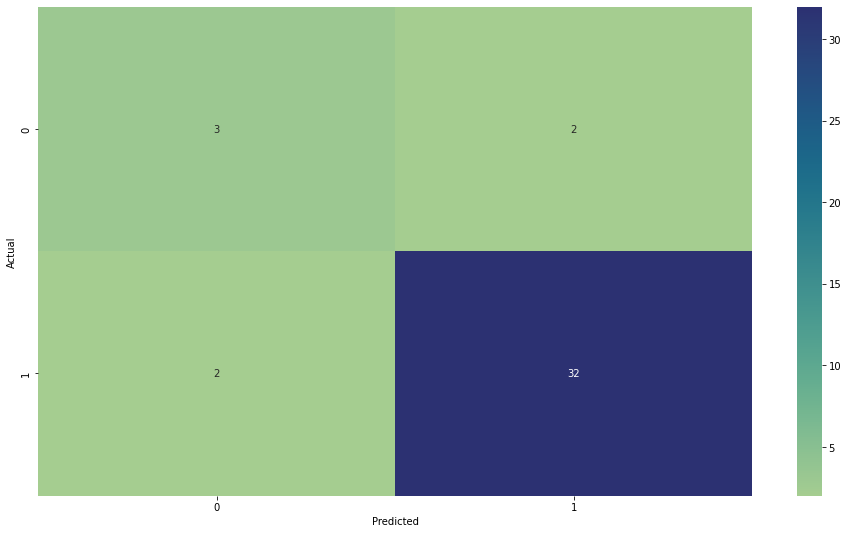

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.94      0.94      0.94        34

    accuracy                           0.90        39
   macro avg       0.77      0.77      0.77        39
weighted avg       0.90      0.90      0.90        39

                   pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.60      0.94      0.60      0.75      0.55         5
          1       0.94      0.94      0.60      0.94      0.75      0.58        34

avg / total       0.90      0.90      0.64      0.90      0.75      0.58        39



In [ ]:
from imblearn.metrics import classification_report_imbalanced
ref_xgb_pred_y = refined_xgb_model.predict(X_test)
def plot_confusion_matrix(y_test, y_pred, color):
    
    plt.rcParams['figure.figsize'] = (16, 9)
   
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=color)
    plt.show()
    
plot_confusion_matrix(np.array(y_test), ref_xgb_pred_y, 'crest')
print(classification_report(y_test, ref_xgb_pred_y))
print(classification_report_imbalanced(y_test, ref_xgb_pred_y))  #, digits=4

Training confusion matrix
[[ 43   0]
 [  0 113]]
Testing confusion matrix
[[ 4  1]
 [ 1 33]]
1.0
0.9487179487179487
Train set:156
Train Accuracy=100.0%
Test set:39
Test Accuracy=94.87179487179486%
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.97      0.97      0.97        34

    accuracy                           0.95        39
   macro avg       0.89      0.89      0.89        39
weighted avg       0.95      0.95      0.95        39

                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.80      0.97      0.80      0.88      0.76         5
          1       0.97      0.97      0.80      0.97      0.88      0.79        34

avg / total       0.95      0.95      0.82      0.95      0.88      0.79        39



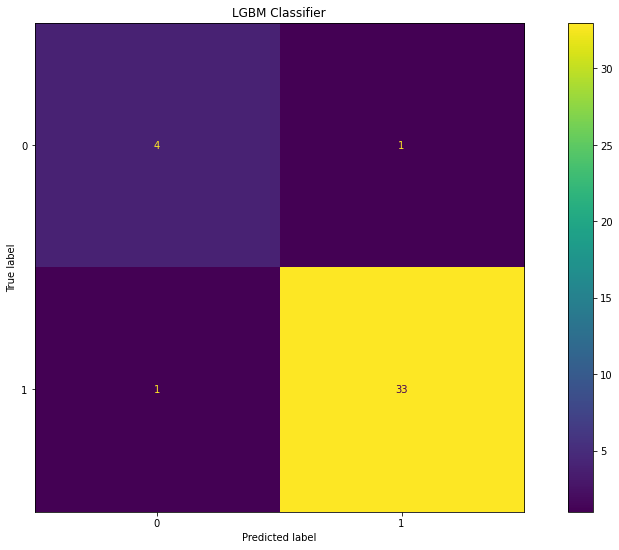

In [ ]:
import lightgbm as lgb
lgb_model= lgb.LGBMClassifier()
lgb_model.fit(X_train,y_train)

from sklearn.metrics import accuracy_score, confusion_matrix
predictions= lgb_model.predict(X_train)
percentage=lgb_model.score(X_train,y_train)
res=confusion_matrix(y_train,predictions)
print("Training confusion matrix")
print(res)
predictions= lgb_model.predict(X_test)
train_percentage=lgb_model.score(X_train,y_train)
test_percentage=lgb_model.score(X_test,y_test)
res = confusion_matrix(y_test,predictions)
print("Testing confusion matrix")
print(res)

# check the accuracy on the training set
print(lgb_model.score(X_train, y_train))
print(lgb_model.score(X_test, y_test))
print(f"Train set:{len(X_train)}")
print(f"Train Accuracy={train_percentage*100}%")
print(f"Test set:{len(X_test)}")
print(f"Test Accuracy={test_percentage*100}%")

print(classification_report(y_test, predictions))
print(classification_report_imbalanced(y_test, predictions)) 
"""
plot_confusion_matrix(lgb_model, X_test, y_test)
plt.show()
"""
cm = confusion_matrix(y_test, predictions, labels=lgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_model.classes_)
disp.plot()
_ = disp.ax_.set_title("LGBM Classifier")
plt.show()

In [ ]:
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
#y_test = y_test.values
print(classification_report(y_test, y_pred))
print(y_test.shape)
y_test = y_test.reshape(-1)
print(y_test.shape)
plot_confusion_matrix(rf, X_test, y_test)
plt.show()
"""

'\nfrom sklearn.ensemble import RandomForestClassifier\nrf = RandomForestClassifier(n_estimators=300, n_jobs=-1)\nrf.fit(X_train,y_train)\ny_pred = rf.predict(X_test)\n#y_test = y_test.values\nprint(classification_report(y_test, y_pred))\nprint(y_test.shape)\ny_test = y_test.reshape(-1)\nprint(y_test.shape)\nplot_confusion_matrix(rf, X_test, y_test)\nplt.show()\n'

In [ ]:
class MyDataset(Dataset):
 
  def __init__(self ,x, y):
    """
    df = pd.read_csv('train.csv')
    df["label"] = df.Survived
#     df = df[df['label'] == 1].reset_index(drop = True)
    df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
    median_age = df.Age.median()
    mode_embarked = df.Embarked.mode()[0]
    df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
    df.Sex = df.Sex.replace({'male':0,'female':1})
    df.Embarked = df.Embarked.replace({'S':0,'C':1,'Q':2})
    """
    
    
    """
    mc = MinMaxScaler(feature_range=(0, 1))
    standard_scaler = mc.fit(x)
    x_scaled = standard_scaler.transform(x)

    x_scaled = pd.DataFrame(x_scaled)
    print(x_scaled.head())
    print(f"y value_count:\n {y.value_counts()}")
    x_scaled = x_scaled.values
    y = y.values
    """
    x = x.values
    y = y.values

    #X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.20, shuffle=True)
    
    #x = x.values
    #y = y.values
    #X_train = X_train.values
    #y_train = y_train.values
    #self.x_train=torch.tensor(x_scaled,dtype=torch.float32)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int)

    print(self.x_train[0:5])
    print(self.y_train[0:5])

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(X_train, y_train)

tensor([[0.1848, 0.2633, 0.0909, 0.0687, 0.0551, 0.1000, 0.0482, 0.0479, 0.0999,
         0.7031, 0.5586, 0.3929, 0.7267, 0.3478, 0.2975],
        [0.0735, 0.1736, 0.2095, 0.1345, 0.1076, 0.1764, 0.1155, 0.0790, 0.1765,
         0.4915, 0.6954, 0.5320, 0.3167, 0.4471, 0.4559],
        [0.3714, 0.0640, 0.0909, 0.4538, 0.4536, 0.5559, 0.4374, 0.2817, 0.5559,
         0.5091, 0.4454, 0.3277, 0.3765, 0.2922, 0.2408],
        [0.3028, 0.0089, 0.2095, 0.2049, 0.1873, 0.2648, 0.1682, 0.1309, 0.2649,
         0.4519, 0.4750, 0.4620, 0.4965, 0.4167, 0.3762],
        [0.0453, 0.1096, 0.2490, 0.2803, 0.2293, 0.3488, 0.2552, 0.1652, 0.3489,
         0.4314, 0.6725, 0.6370, 0.3350, 0.5439, 0.5870]])
tensor([1, 1, 1, 1, 1], dtype=torch.int32)


In [ ]:
#train_ds.info()

In [ ]:
batch_size = 32 #64


train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
train_dl.device

device(type='cuda')

# Creating generator and discriminator models

<b> Generator Architecture

In [ ]:
latent_size = 15 # origin is 7
n_features = 15  # equal to columns
num_classes = 2
embed_size = 2  # classes number?

In [ ]:
class Generator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            #nn.Linear(32, 7),
            nn.Linear(32, 15)   # the last number is equal to columns
            
#             nn.Linear(latent_size, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 7),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels)#.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    

generator = to_device(Generator(), device)

<b> Discriminator Architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, embed_size = 2):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_features + embed_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
#             nn.Linear(n_features, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(512, 256),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(256, 128),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(128, 64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(64, 32),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(32, 16),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.2),
            
#             nn.Linear(16, 1),
#             nn.Sigmoid()
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embed = self.embed(labels) #.reshape(labels.shape[0], 1)
        x = torch.cat([x, embed], dim = 1)
        output = self.model(x)
        return output
    
discriminator = to_device(Discriminator(), device)

In [ ]:
# for arr, labels in train_dl:
#     break
# # nn.Embedding(2, 2).to('cuda')(labels)#.reshape(labels.shape[0], 1)

# Generator and discriminator training methodology

In [ ]:
CRITIC_ITERATIONS = 5
# WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [ ]:
def gradient_penalty(real_data, generated_data, real_labels,device = device):
    BATCH_SIZE, features_count = real_data.shape
    epsilon = torch.rand((BATCH_SIZE, features_count)).to(device)
    epsilon = epsilon.to(device)

    interpolated_data = real_data * epsilon + generated_data * (1 - epsilon)


    # lets calculate critics score
    mixed_scores = discriminator(interpolated_data, real_labels)

    # Computes and returns the sum of gradients of outputs with respect to the inputs.
    # https://pytorch.org/docs/stable/generated/torch.ones_like.html
    # l2 norm : https://www.analyticsvidhya.com/blog/2021/03/must-known-vector-norms-in-machine-learning/
    gradient = torch.autograd.grad(
      inputs = interpolated_data,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores)
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(real_data, opt_d, cur_batch_size, real_labels):
    # Reset gradients
    opt_d.zero_grad()
    
    real_labels = real_labels.to(device)
    real_preds = discriminator(real_data, real_labels).reshape(-1)

    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels).reshape(-1)
    
    # calculating gradient penalty
    gp = gradient_penalty(real_data, generated_data, real_labels,device = device)
    
    loss = -(torch.mean(real_preds) - torch.mean(fake_preds)) + LAMBDA_GP * gp

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
        
    return loss

In [ ]:
def train_generator(opt_g, cur_batch_size, real_labels):
    # Clear generator gradients
    opt_g.zero_grad()
     
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_size),  device = device)
    generated_data = generator(latent_space_samples, real_labels)  # fake data generated by generator
    fake_preds = discriminator(generated_data, real_labels.to(device)).reshape(-1)
    g_loss = -torch.mean(fake_preds)

    g_loss.backward()
    opt_g.step()
    return g_loss

# Training Loop

In [ ]:
lr = 0.001
epochs = 100 #1000

In [ ]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.9))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.9))

In [ ]:
def fit(epochs, lr, opt_d, opt_g):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []

    
    # Create optimizers
#     opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
#     opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    total_step = len(train_dl)
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(train_dl):
            cur_batch_size = real_data.shape[0]
            
            for _ in range(CRITIC_ITERATIONS):            
                # Train the discriminator and generator
                d_loss = train_discriminator(real_data, opt_d, cur_batch_size, real_labels)            
                
            g_loss = train_generator(opt_g, cur_batch_size, real_labels)
            
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item()))
        # Loss of last batch
        losses_d.append(d_loss.item())
        losses_g.append(g_loss.item())
        #leon-plot generator and disciminator loss
        #if plot:
        if epoch+1==epochs:
          plt.figure(figsize=(10,5))
          plt.title("Generator and Discriminator Loss")
          plt.plot(losses_g,label="G")
          plt.plot(losses_d,label="D")
          plt.xlabel("iterations")
          plt.ylabel("Loss")
          plt.legend()
          plt.show()
        #
    return losses_g, losses_d

Epoch [0/1000], Step [1/5], d_loss: 9.4419, g_loss: -0.4991
Epoch [0/1000], Step [2/5], d_loss: 7.9653, g_loss: -0.4202
Epoch [0/1000], Step [3/5], d_loss: 4.7273, g_loss: -0.2870
Epoch [0/1000], Step [4/5], d_loss: 0.7991, g_loss: -0.1218
Epoch [0/1000], Step [5/5], d_loss: 1.6685, g_loss: -0.0479
Epoch [1/1000], Step [1/5], d_loss: 6.7966, g_loss: -0.0307
Epoch [1/1000], Step [2/5], d_loss: 14.0247, g_loss: -0.0202
Epoch [1/1000], Step [3/5], d_loss: 19.5539, g_loss: -0.0059
Epoch [1/1000], Step [4/5], d_loss: 23.9692, g_loss: -0.0024
Epoch [1/1000], Step [5/5], d_loss: 31.7163, g_loss: -0.0097
Epoch [2/1000], Step [1/5], d_loss: 33.7378, g_loss: -0.0011
Epoch [2/1000], Step [2/5], d_loss: 50.2161, g_loss: -0.0008
Epoch [2/1000], Step [3/5], d_loss: 41.2423, g_loss: -0.0183
Epoch [2/1000], Step [4/5], d_loss: 58.5951, g_loss: -0.0003
Epoch [2/1000], Step [5/5], d_loss: 65.4672, g_loss: -0.0002
Epoch [3/1000], Step [1/5], d_loss: 54.5467, g_loss: -0.0002
Epoch [3/1000], Step [2/5], d_

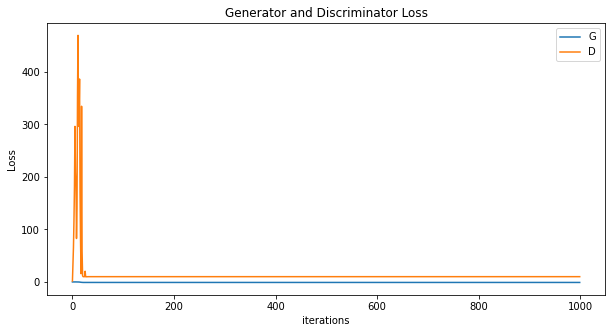

CPU times: user 2min 33s, sys: 2.86 s, total: 2min 36s
Wall time: 2min 56s


In [ ]:
%%time

history = fit(epochs, lr, opt_d, opt_g)

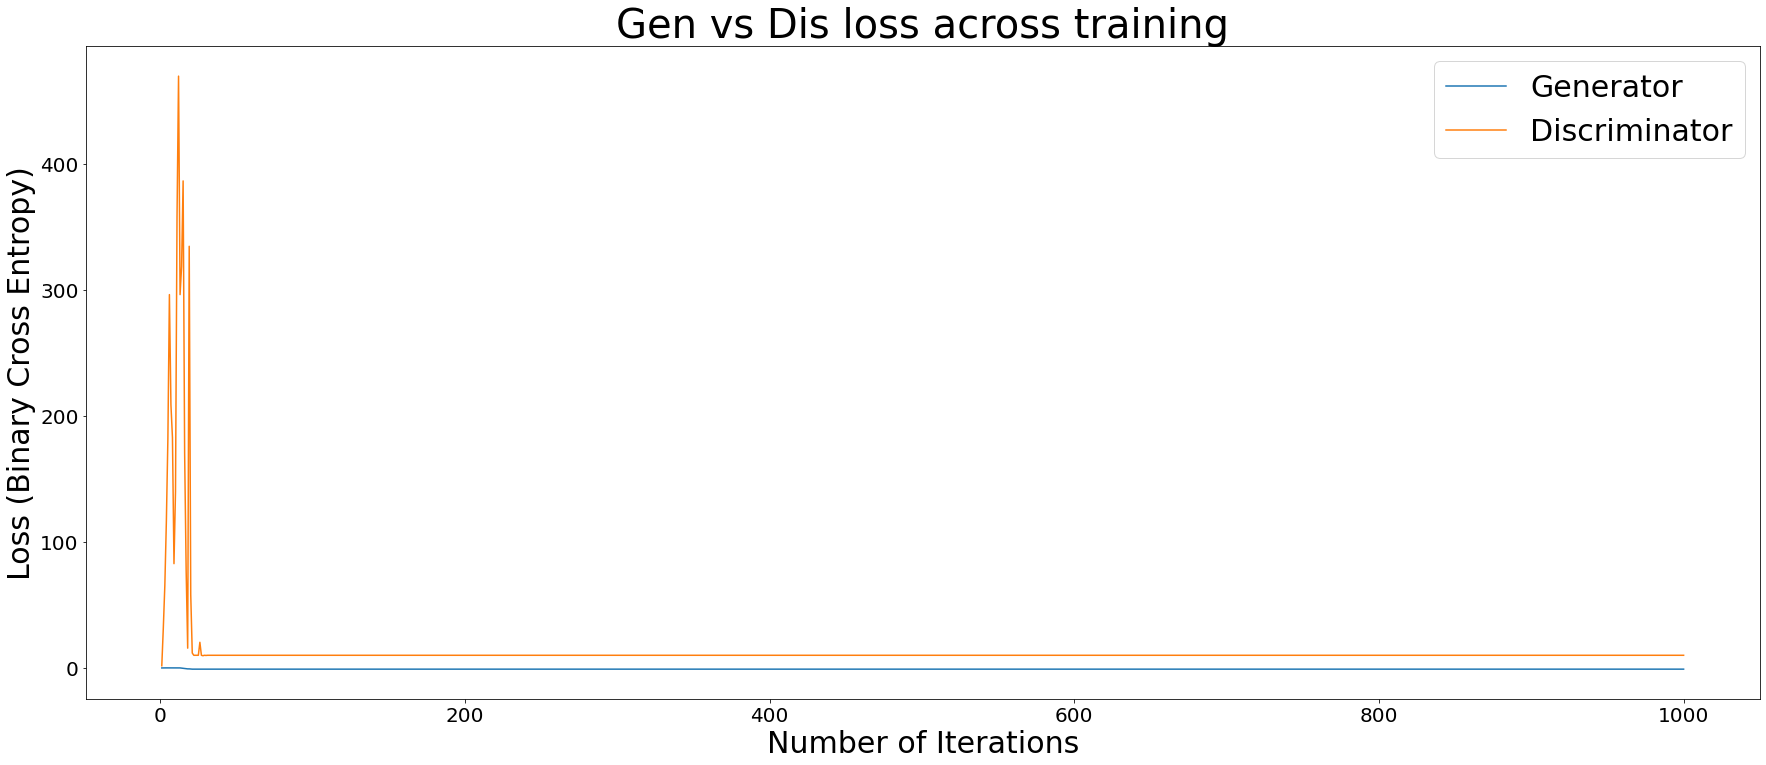

In [ ]:
losses_g, losses_d = history[0], history[1]

fig, axes = plt.subplots(1,1, figsize=(30, 12))
ax1 = plt.subplot(1,1,1)

plt.plot(range(1,1001), losses_g, label = 'Generator')
plt.plot(range(1, 1001), losses_d, label = 'Discriminator')
ax1.tick_params(labelsize = 20)
ax1.set_xlabel('Number of Iterations', fontsize = 30)
ax1.set_ylabel('Loss (Binary Cross Entropy)', fontsize = 30)
plt.title('Gen vs Dis loss across training', fontsize = 40)
plt.legend(fontsize = 30)

# Testing Generated Samples from Trained Generator

In [ ]:
#df.label.value_counts()

In [ ]:
def generate_samples(number_of_samples_to_generate, class_val):
    if class_val == 0:
        label = torch.zeros(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 0
    elif class_val == 1:
        label = torch.ones(number_of_samples_to_generate, dtype=torch.int).to(device)  #generate for class 1
        
        
    latent_space_samples = torch.randn(number_of_samples_to_generate, n_features).to(device)
    generated_samples = generator(latent_space_samples, label)
#     print('generated_samples: ', generated_samples.shape)
#     print('label: ', label.shape)
    generated_samples = torch.concat([generated_samples, label.reshape(number_of_samples_to_generate, 1)], \
                                     dim = 1)
    generated_samples = generated_samples.cpu().detach().numpy()
    df_generated = pd.DataFrame(generated_samples, columns = df.columns)  #assign columns
    #df_generated = pd.DataFrame(generated_samples)  # don't assign columns, leon
    return df_generated

In [ ]:
#df_generated_0 = generate_samples(549, 0)
df_generated_0 = generate_samples(1980, 0)
df_generated_0["status"] = 0
df_generated_0.info()
df_generated_0.head()
print(df_generated_0.head())
#df_generated_1 = generate_samples(342, 1)
df_generated_1 = generate_samples(1900, 1)
df_generated_1["status"] = 1
print(df_generated_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       1980 non-null   float32
 1   MDVP:Flo(Hz)      1980 non-null   float32
 2   MDVP:Jitter(Abs)  1980 non-null   float32
 3   MDVP:Shimmer      1980 non-null   float32
 4   MDVP:Shimmer(dB)  1980 non-null   float32
 5   Shimmer:APQ3      1980 non-null   float32
 6   Shimmer:APQ5      1980 non-null   float32
 7   MDVP:APQ          1980 non-null   float32
 8   Shimmer:DDA       1980 non-null   float32
 9   HNR               1980 non-null   float32
 10  status            1980 non-null   int64  
 11  RPDE              1980 non-null   float32
 12  spread1           1980 non-null   float32
 13  spread2           1980 non-null   float32
 14  D2                1980 non-null   float32
 15  PPE               1980 non-null   float32
dtypes: float32(15), int64(1)
memory usage: 131

Concatenate dataset

In [ ]:
df_gan = pd.concat([df_generated_1, df_generated_0], ignore_index=True, sort=False)  #leon
df_gan = df_gan.sample(frac=1).reset_index(drop=True)  #用于从DataFrame中随机选择行和列。

y_train_gan = df_gan['status']
X_train_gan = df_gan.drop('status',axis='columns')
#print(X_train_2.iloc[0:5])pe
#y_train_gan = df_gan['LUNG_CANCER'].values
#y_train_gan = df_gan['LUNG_CANCER']
print("X:", X_train_gan.head())
print("Y：", y_train_gan.head())



#y_train_2_d = df_gan['LUNG_CANCER']

#transform to narray lost column name
X_train_gan = X_train_gan.values
y_train_gan = y_train_gan.values
#transforms to dataframe again
X_train_gan = pd.DataFrame(X_train_gan)
y_train_gan = pd.DataFrame(y_train_gan)

print(f"X_train_gan shape: {X_train_gan.shape}")
print(f"y_train_gan shape: {y_train_gan.shape}")

# transform and lost column name for concatenation
origin_df_x = pd.DataFrame(X_train.values)
origin_df_y = pd.DataFrame(y_train.values)


#X_train_2_e =  X_train_2.values

#origin_df - pd.merge(origin_df_x,origin_df_y)
#origin_df.info()
#origin_df.head()

#X_train_2_d = pd.DataFrame(X_train_2_e)

X_train_fin = pd.concat([origin_df_x, X_train_gan], axis=0, ignore_index=True)       
y_train_fin = pd.concat([origin_df_y, y_train_gan], axis=0, ignore_index=True)
print('X', X_train_fin.count())
print('y:',y_train_fin.count())
print('X', X_train_fin.shape)
print('y:',y_train_fin.shape)


#print("y count(）", y_train_fin.value_counts())
print(X_train_fin.head())
print(y_train_fin.head())

X:    MDVP:Fo(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(Abs)  MDVP:Shimmer  \
0     0.582194      0.676156          0.131839      0.489013   
1     0.637118      0.481327          0.021412      0.357081   
2     0.712714      0.958183          0.211381      0.605948   
3     0.685535      0.913514          0.316534      0.538468   
4     0.547677      0.659903          0.171868      0.533445   

   MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimmer:DDA  \
0          0.138020      0.192704      0.444675  0.241983     0.342143   
1          0.105385      0.148267      0.191601  0.215852     0.323816   
2          0.239720      0.300339      0.615707  0.363157     0.237374   
3          0.212988      0.303425      0.619949  0.295465     0.289727   
4          0.093392      0.171506      0.414686  0.137595     0.258359   

        HNR      RPDE   spread1   spread2        D2  PPE  
0  0.974056  0.741391  0.550598  0.691113  0.560928  0.0  
1  0.734119  0.698242  0.496623  0.604157  0.5619

In [ ]:
"""
import xgboost as xgb2
xgb2 = xgb2.XGBClassifier()
y_train_fin = y_train_fin.values.ravel()

xgb2.fit(X_train_fin,y_train_fin)

y_pred = xgb2.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb2, X_test, y_test)
plt.show()
"""  

'\nimport xgboost as xgb2\nxgb2 = xgb2.XGBClassifier()\ny_train_fin = y_train_fin.values.ravel()\n\nxgb2.fit(X_train_fin,y_train_fin)\n\ny_pred = xgb2.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(xgb2, X_test, y_test)\nplt.show()\n'

In [ ]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, 
                             scoring='accuracy', n_jobs=-1, cv=2)

p_grid_search.fit(X_train_fin,y_train_fin)


GridSearchCV(cv=2,
             estimator=xgb.XGBClassifier(base_score=None, booster=None,   #leon  add xgb before xgbclassifier
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=None, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9777006937561943)

In [ ]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4)
refined_xgb_model.fit(X_train_fin,y_train_fin)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

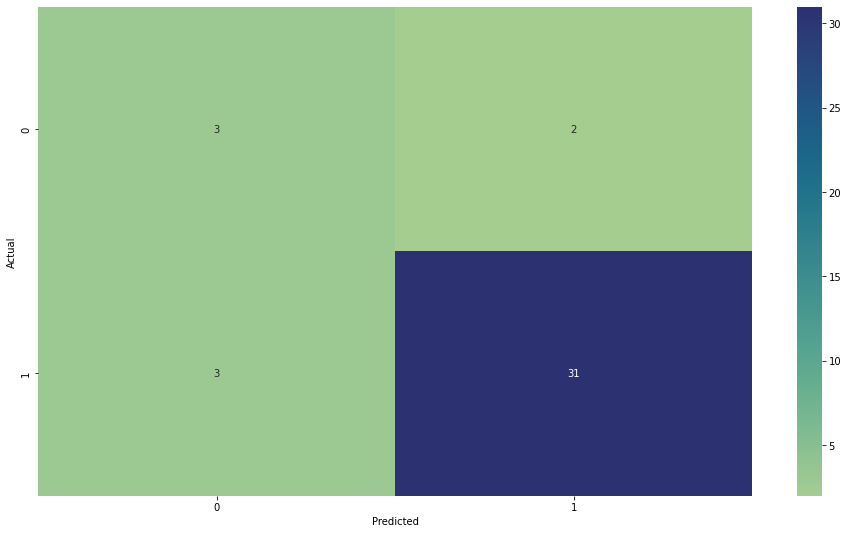

              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.94      0.91      0.93        34

    accuracy                           0.87        39
   macro avg       0.72      0.76      0.74        39
weighted avg       0.88      0.87      0.88        39

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.60      0.91      0.55      0.74      0.53         5
          1       0.94      0.91      0.60      0.93      0.74      0.56        34

avg / total       0.88      0.87      0.64      0.88      0.74      0.56        39



In [ ]:
#from imblearn.metrics import classification_report_imbalanced
ref_xgb_pred_y = refined_xgb_model.predict(X_test)
def plot_confusion_matrix(y_test, y_pred, color):
    
    plt.rcParams['figure.figsize'] = (16, 9)
   
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap=color)
    plt.show()
    
plot_confusion_matrix(np.array(y_test), ref_xgb_pred_y, 'crest')
print(classification_report(y_test, ref_xgb_pred_y))
print(classification_report_imbalanced(y_test, ref_xgb_pred_y))  #, digits=4

In [ ]:
"""
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf.fit(X_train_fin,y_train_fin)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, X_test, y_test)
plt.show()
"""

'\nfrom sklearn.ensemble import RandomForestClassifier\nrf = RandomForestClassifier(n_estimators=300, n_jobs=-1)\nrf.fit(X_train_fin,y_train_fin)\ny_pred = rf.predict(X_test)\n\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(rf, X_test, y_test)\nplt.show()\n'

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.91      0.94      0.93        34

    accuracy                           0.87        39
   macro avg       0.71      0.67      0.69        39
weighted avg       0.86      0.87      0.87        39

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.40      0.94      0.44      0.61      0.36         5
          1       0.91      0.94      0.40      0.93      0.61      0.40        34

avg / total       0.86      0.87      0.47      0.87      0.61      0.39        39

[0 1]


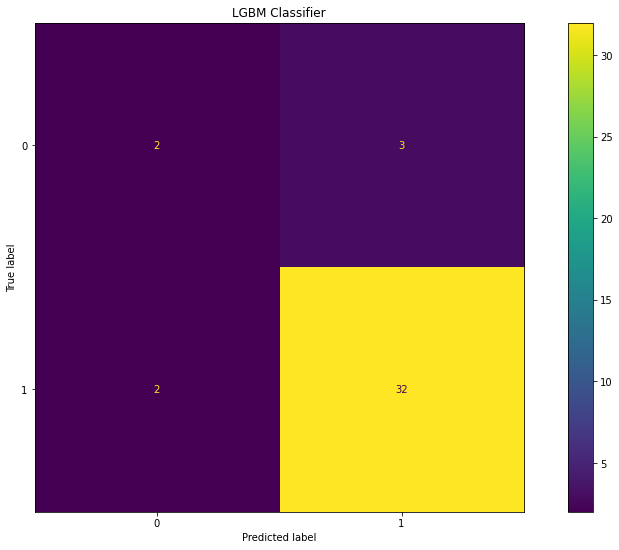

In [ ]:
lgb_2 = lgb.LGBMClassifier()

#y_train_3 = y_train_3.values
#y_train_3 = y_train_3.ravel()
lgb_2.fit(X_train_fin,y_train_fin)

y_pred = lgb_2.predict(X_test)


print(classification_report(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))
"""
plot_confusion_matrix(lgb_2, X_test, y_test)
plt.show()
"""
print(lgb_2.classes_)

cm = confusion_matrix(y_test, y_pred, labels=lgb_2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_2.classes_)
disp.plot()
_ = disp.ax_.set_title("LGBM Classifier")
plt.show()

# Checking distributions of synthetic data(temporily not used)

In [ ]:
"""
import warnings
warnings.filterwarnings("ignore")
"""

In [ ]:
"""
df0 = df[df.LUNG_CANCER == 0]
#df1 = df[df.label == 1]
df1 = df[df.LUNG_CANCER == 1]

mc = MinMaxScaler(feature_range=(0, 1))
standard_scaler0 = mc.fit(df0)
df0 = standard_scaler0.transform(df0)
#x_scaled = pd.DataFrame(df0)

standard_scaler1 = mc.fit(df1)
df1 = standard_scaler1.transform(df1)

print(df0[0:5])
print(df1[0:5])
"""

AttributeError: ignored

<b> For class 0

In [ ]:
"""
print('FOR CLASS 0')
fig, axes = plt.subplots(16, 1, figsize=(10, 50))  # must change plot number

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)  # must change plot number
    sns.distplot(x = df_generated_0[col], color = 'red', label = 'Generated')
    sns.distplot(x = df0[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12)  # 30
    plt.xlabel(col, fontsize = 12)  #30 
    plt.title(col, fontsize = 12)   #30
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
"""

<b> For class 1

In [ ]:
"""
print('FOR CLASS 1')
fig, axes = plt.subplots(16, 1, figsize=(10, 50)) #must change font size 

for n, col in enumerate(df.columns.to_list()[:-1]):
    ax1 = plt.subplot(16,1, n+1)
    sns.distplot(x = df_generated_1[col], color = 'red', label = 'Generated')
    sns.distplot(x = df1[col], color = 'blue', label = 'real')
    plt.legend(fontsize = 12) # #30
    plt.xlabel(col, fontsize = 12)
    plt.title(col, fontsize = 12)
    plt.ylabel(' ')
plt.subplots_adjust(wspace=0.5,hspace=0.5)
"""

Asssessment